## Ocean Drift Diagnostics

### Import Modules

In [1]:
import sys
#sys.path.insert(0, '../..')
from IPython import get_ipython
from IPython.lib.deepreload import reload

%load_ext autoreload
%autoreload 2
from aqua import Reader,catalogue, inspect_catalogue
from ocean3d import check_variable_name
from ocean3d import hovmoller_plot
from ocean3d import time_series

from ocean3d import multilevel_trend
from ocean3d import zonal_mean_trend
# from aqua.util import load_yaml

### Import Data

Here we read one of the reference NextGEMS Cycle 3 simulations
And we extract the Potential Temperature and Practical Salinity fields, resampling in yearly means (as these are more adequate to identify drifts as they are not contaminated by seasonal cycle signals)

In [2]:
reader = Reader(model='IFS-NEMO', exp='historical-1990', source="lra-r100-monthly")

data = reader.retrieve(startdate="1990", enddate="1990")
data = check_variable_name(data)

data

2024-03-15 16:59:47 :: Reader :: WARNING  -> The requested default fixer name IFS-NEMO-default does not exist in fixes files
2024-03-15 16:59:47 :: Reader :: WARNING  -> No fixes available for model IFS-NEMO, experiment historical-1990, source lra-r100-monthly
2024-03-15 16:59:52 :: Unit :: WARNING  -> The unit of Pot. Temperature is Kelvin. Converting to degC


<xarray.Dataset>
Dimensions:      (time: 12, lat: 180, lon: 360, lev: 75, plev: 19)
Coordinates:
  * time         (time) datetime64[ns] 1990-01-01 1990-02-01 ... 1990-12-01
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    idx_level    (lev) int64 dask.array<chunksize=(75,), meta=np.ndarray>
  * plev         (plev) float64 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
Data variables: (12/37)
    2t           (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    avg_hc700m   (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    avg_siconc   (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    avg_sithick  (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    avg_so       (time, lev, lat, lon) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    avg_sos      (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    ...           ...
    tcc          (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    tciw         (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    tclw         (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    tprate       (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    u            (time, plev, lat, lon) float64 dask.array<chunksize=(12, 19, 180, 360), meta=np.ndarray>
    v            (time, plev, lat, lon) float64 dask.array<chunksize=(12, 19, 180, 360), meta=np.ndarray>
Attributes:
    history:  \n2024-03-15 16:59:52 AQUA💧: Retrieved from IFS-NEMO_historical...

In [3]:
o3d_request= {'model':'IFS-NEMO',
'exp':'historical-1990',
'source': 'lra-r100-monthly',
'data': data,
'region':'Atlantic Ocean',
'latS':None,
'latN':None,
'lonW':None,
'lonE':None,
'output':True,
'output_dir':'./output'}

### Functions:
All functions (primary and secondary) can be found in global_ocean

The four main diagnostic functions are:
1. ##### hovmoller_lev_time_plot

hovmoller_lev_time_plot(data, region, anomaly: bool = False,standardise: bool =False, anomaly_ref= None , latS: float=None, latN: float=None, lonW: float=None,lonE: float=None, output= False, output_dir= None)

This function produces hovmollers in depth and time of yearly potential ocean temperature and practical salinity spatially averaged over a predefined ocean region or a customised lat-lon box. Its intended to be used only with model data goal and its goal is to help identify potential drifts at different ocean levels.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- The specific region over which the spatial average is computed (or to provide a custom latxlon box instead)
- A choice on how to preprocess the data, allowing the user to decide
    - Whether anomalies are to be computed
    - Whether anomalies are to be normalised
    - The reference for the computation of the anomalies (either the first time step or the whole temporal mean) 


2. ##### time_series_multilevs
time_series_multilevs(data, region=None, anomaly: bool = False, standardise: bool =False, anomaly_ref = None, customise_level=False, levels=None, latS: float=None, latN: float=None, lonW: float=None,lonE: float=None,  output= True, output_dir = None)

This function produces timeseries of yearly potential ocean temperature and practical salinity spatially averaged over a predefined ocean region or a customised lat-lon box for a set of selected levels. Its intended to be used only with model data goal and its goal is to help identify potential drifts at different ocean levels.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- The specific region over which the spatial average is computed (or to provide a custom latxlon box instead)
- A choice on how to preprocess the data, allowing the user to decide
    - Whether anomalies are to be computed
    - Whether anomalies are to be normalised
    - The reference for the computation of the anomalies (either the first time step or the whole temporal mean) 
- The choice on the vertical levels to include in the plot (by default: 0, 100, 500, 1000, 2000, 3000, 4000, 5000)


3. ##### multilevel_t_s_trend_plot
multilevel_t_s_trend_plot(data, region=None, customise_level=False, levels=None, latS: float=None, latN: float=None, lonW: float=None, lonE: float=None,  output= True, output_dir =  output_dir)

This function produces plots with the linear trends in time at the grid point levels for a set of selected levels. It helps to identify the areas and depths where the stronger trends (and potential drifts) are developping.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- The specific region to be shown in the plots
- The choice on the vertical levels to include in the plot (by default: 10, 100, 500, 1000, 3000, 5000)

4. ##### zonal_mean_trend_plot
zonal_mean_trend_plot(data, region=None, latS: float=None, latN: float=None, lonW: float=None, lonE: float=None,  output= True, output_dir =  output_dir):

This function produces plots of zonally averaged linear trends in time as a function of depth and latitude over a selected region. It helps to identify the latitudes and depths where the stronger trends (and potential drifts) are developping.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- The specific region over which the zonal averages are computed and shown


/LUMI_TYKKY_0yI4stR/miniconda/envs/env1/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/LUMI_TYKKY_0yI4stR/miniconda/envs/env1/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/pfs/lustrep3/scratch/project_465000454/sughosh/AQUA/diagnostics/ocean3d/ocean3d/ocean_drifts/hovmoller_plot.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), rotation=30)
/pfs/lustrep3/scratch/project_465000454/sughosh/AQUA/diagnostics/ocean3d/ocean3d/ocean_drifts/hovmoller_plot.py:143: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,1].set_xticklabels(axs[i,0].get_xticklabels(), rotation=30)


/LUMI_TYKKY_0yI4stR/miniconda/envs/env1/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/LUMI_TYKKY_0yI4stR/miniconda/envs/env1/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


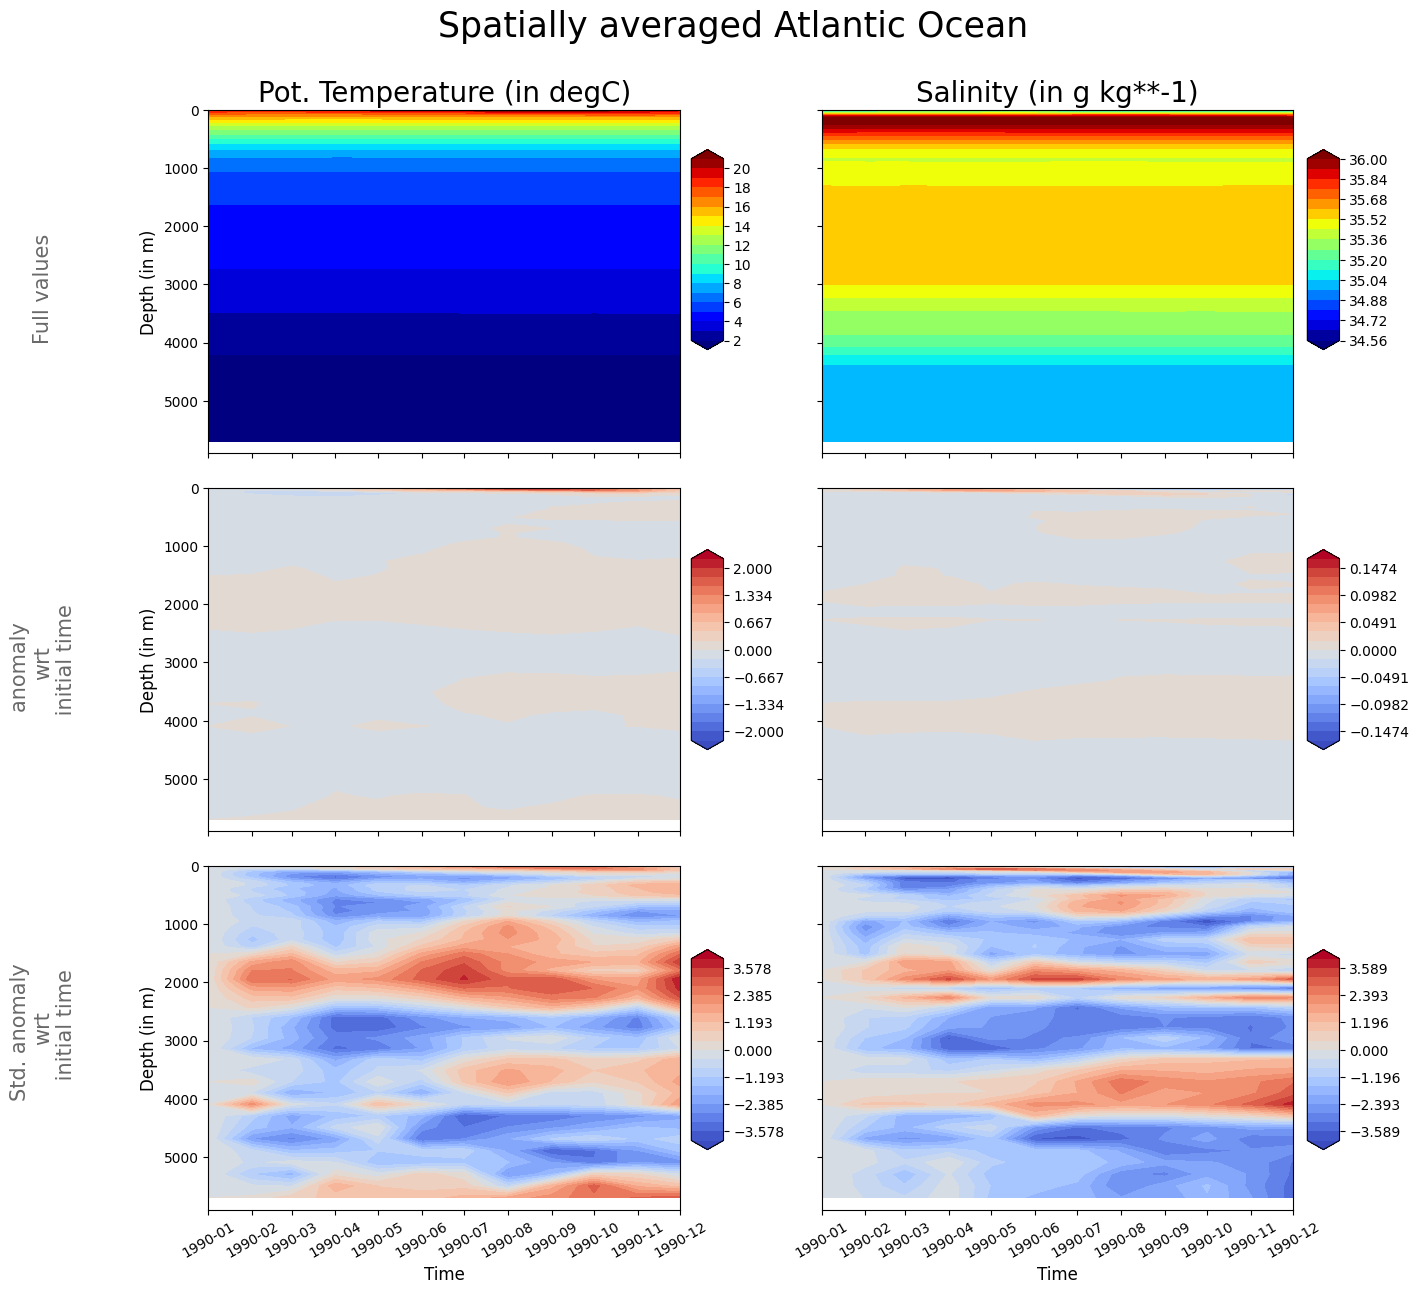

In [4]:
hovmoller_plot_init = hovmoller_plot(o3d_request)
hovmoller_plot_init.plot() 

This example is for the function that plots timeseries of Globally averaged yearly full values of ocpt and so at the default depth levels

/pfs/lustrep3/scratch/project_465000454/sughosh/AQUA/diagnostics/ocean3d/ocean3d/ocean_drifts/time_series.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,1].set_title('')
/pfs/lustrep3/scratch/project_465000454/sughosh/AQUA/diagnostics/ocean3d/ocean3d/ocean_drifts/time_series.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  


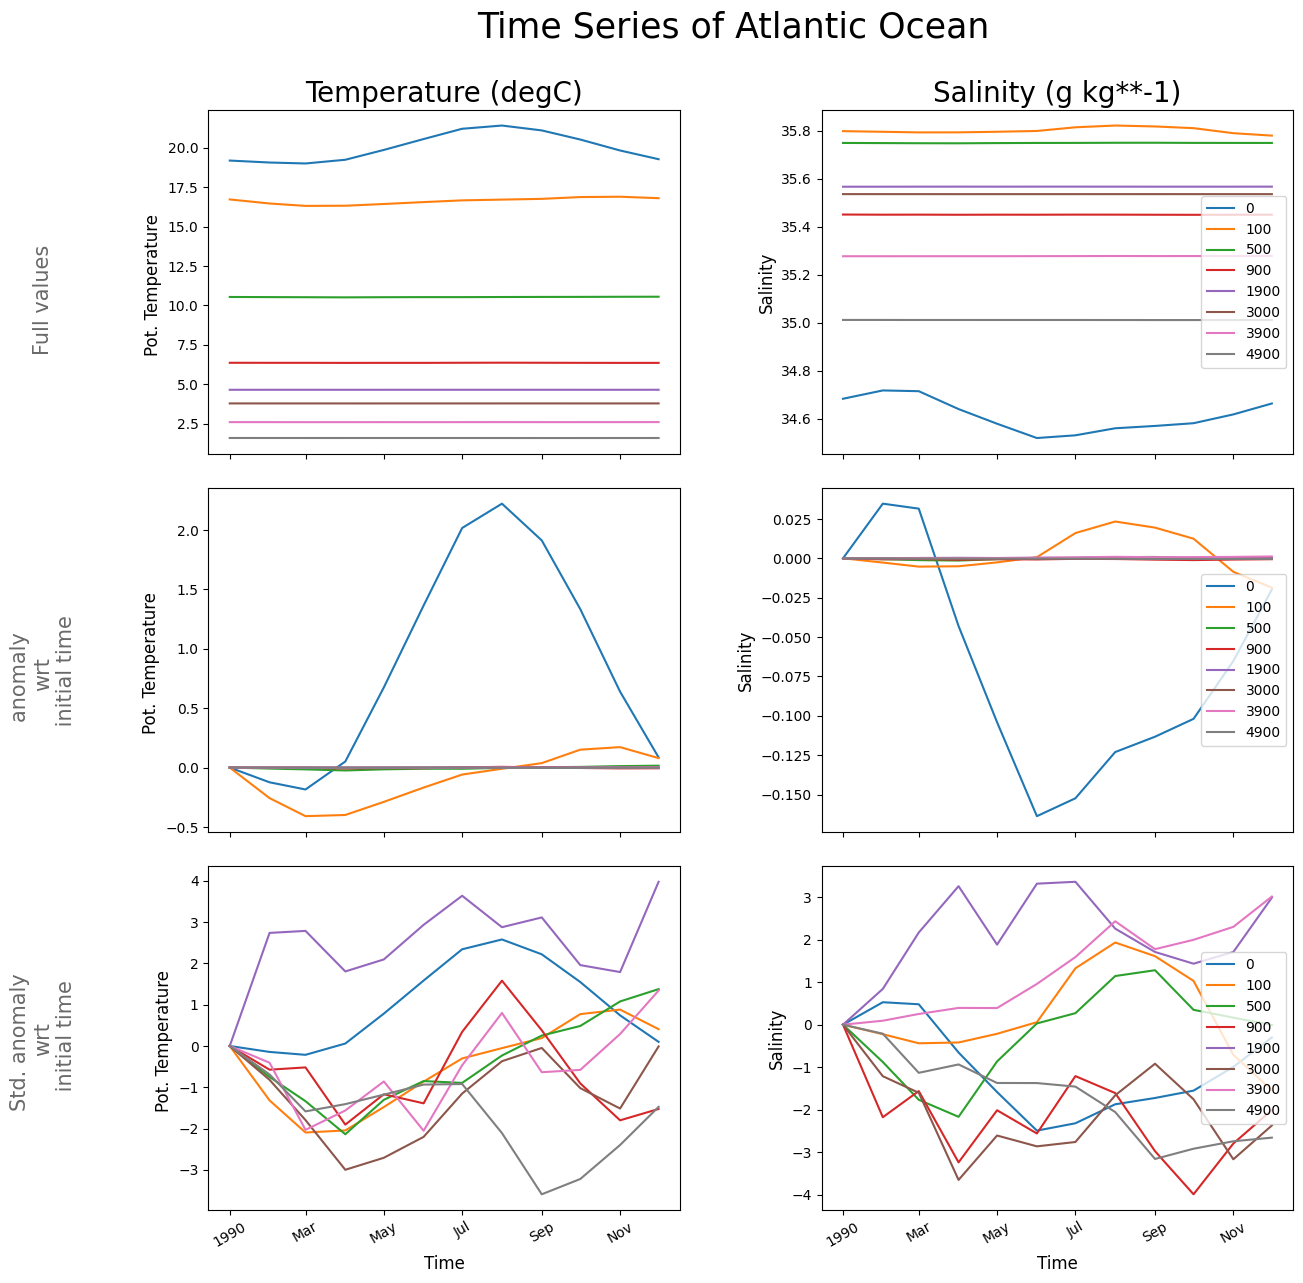

In [7]:
time_ser = time_series(o3d_request)
time_ser.plot()

This is an example  for the function that plots maps of temporal trends (computed for all years in the dataset) and plots them for the whole Global Ocean for the default list of vertical levels


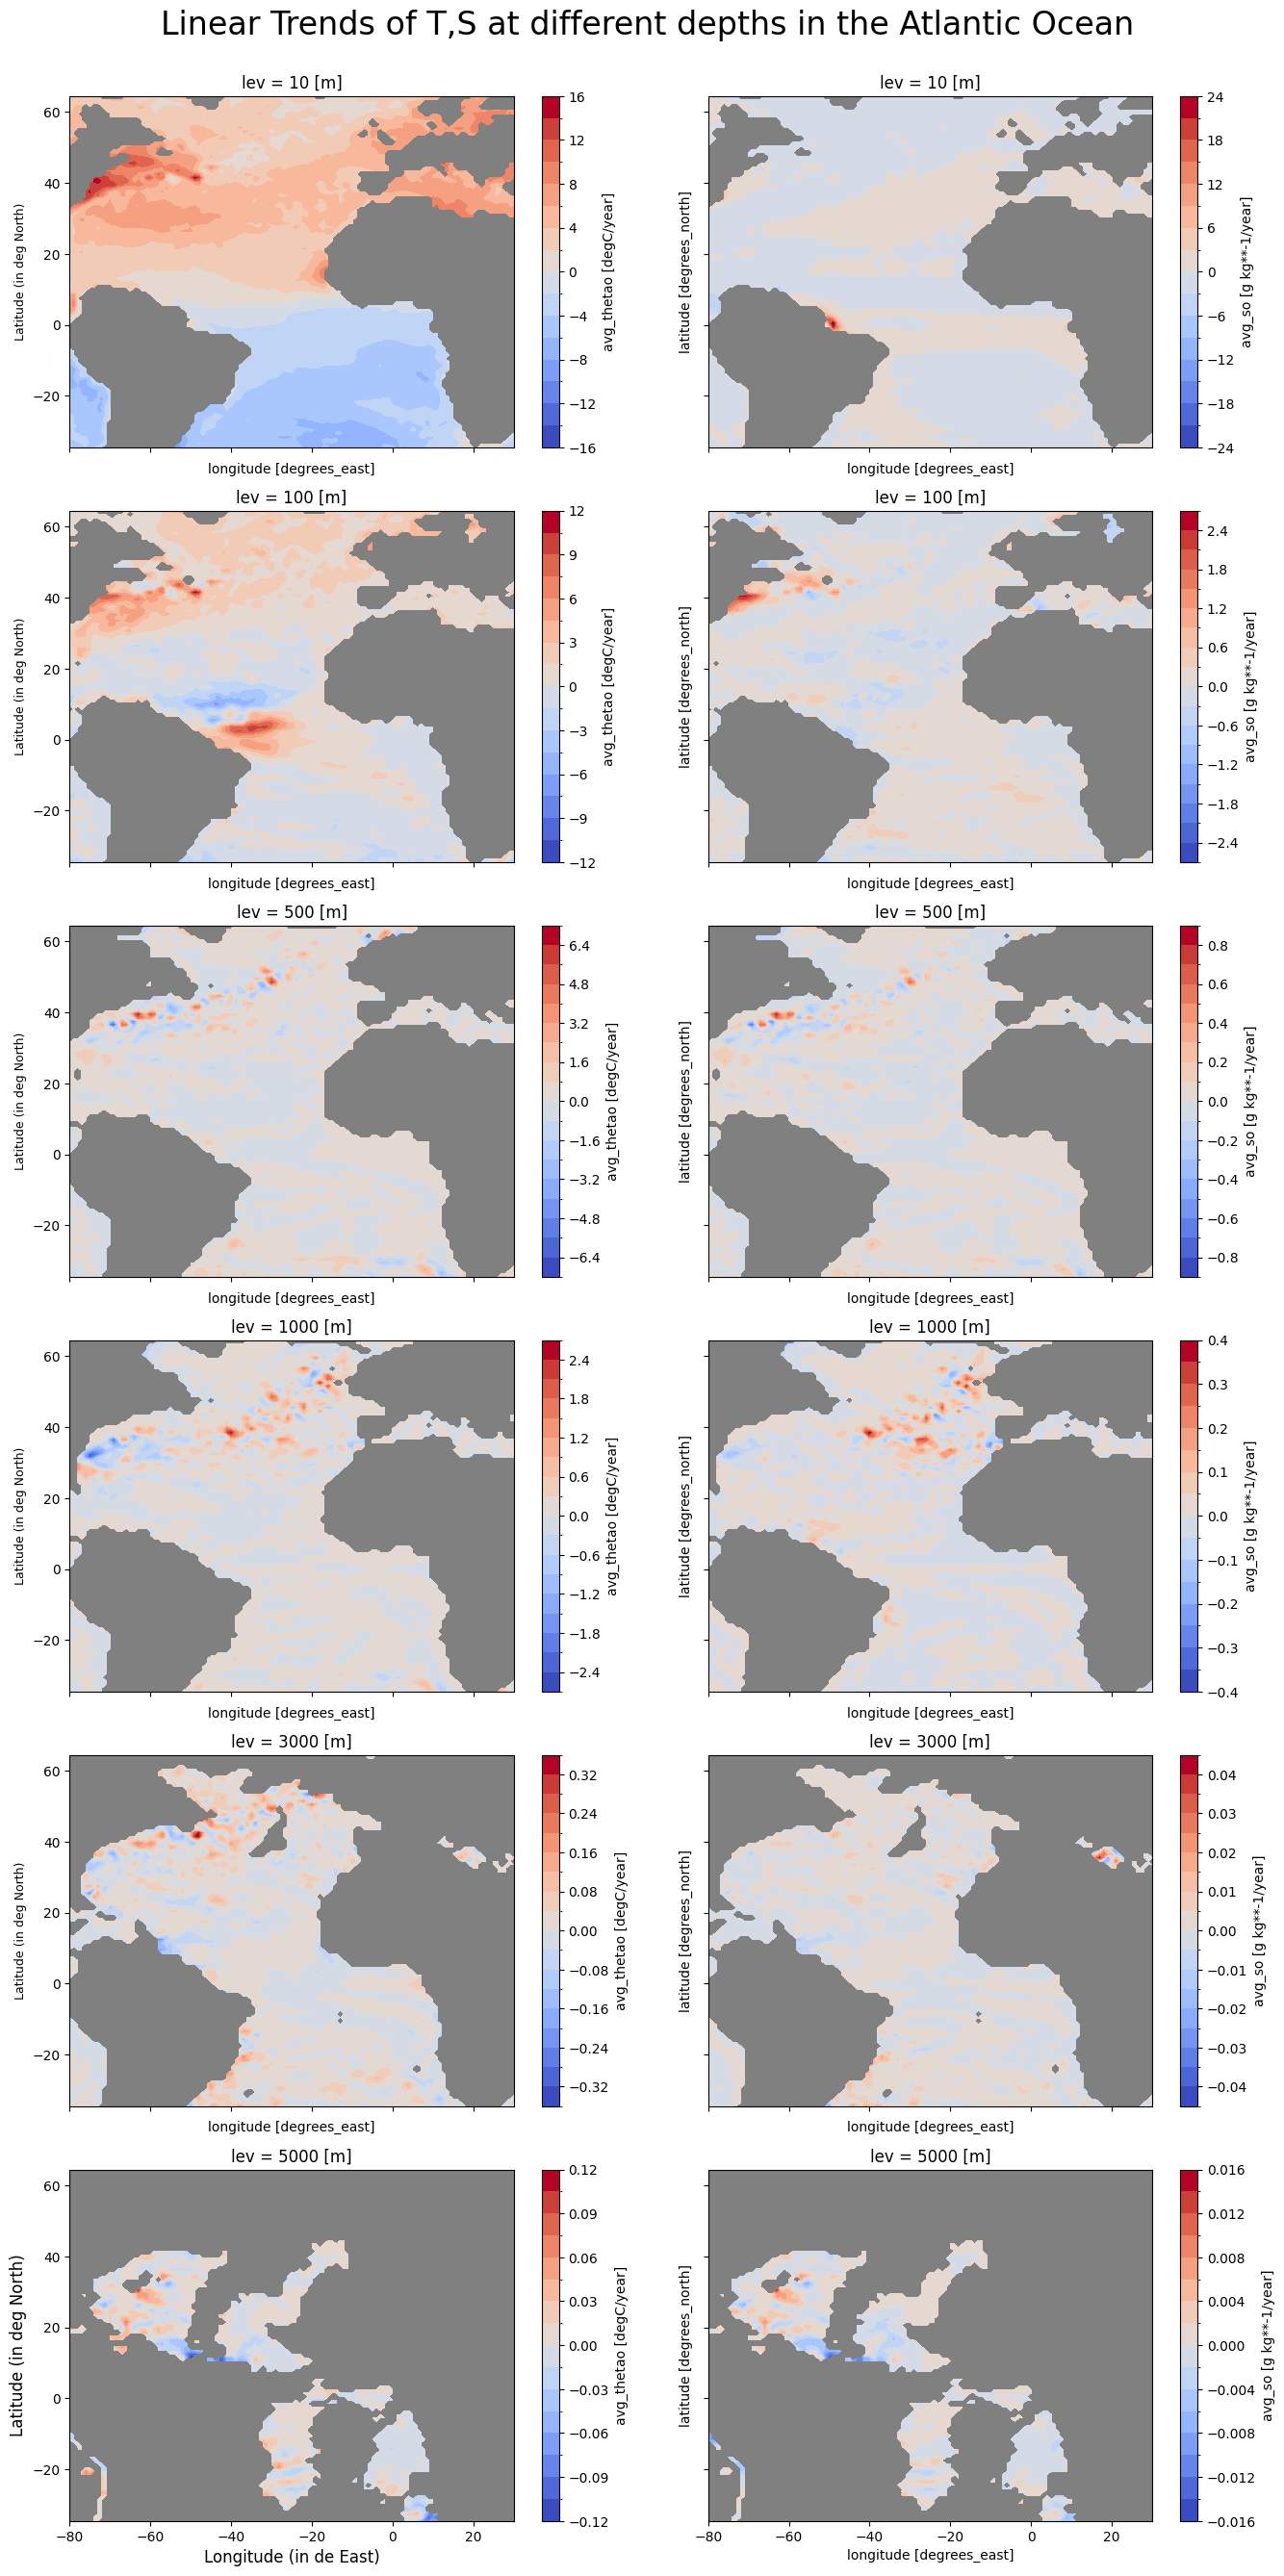

In [12]:
trend = multilevel_trend(o3d_request)
trend.plot()


This is another example for the function that plots maps of temporal trends (computed for all years in the dataset) cropped now to the Atlantic Ocean and shown for a customised list of levels

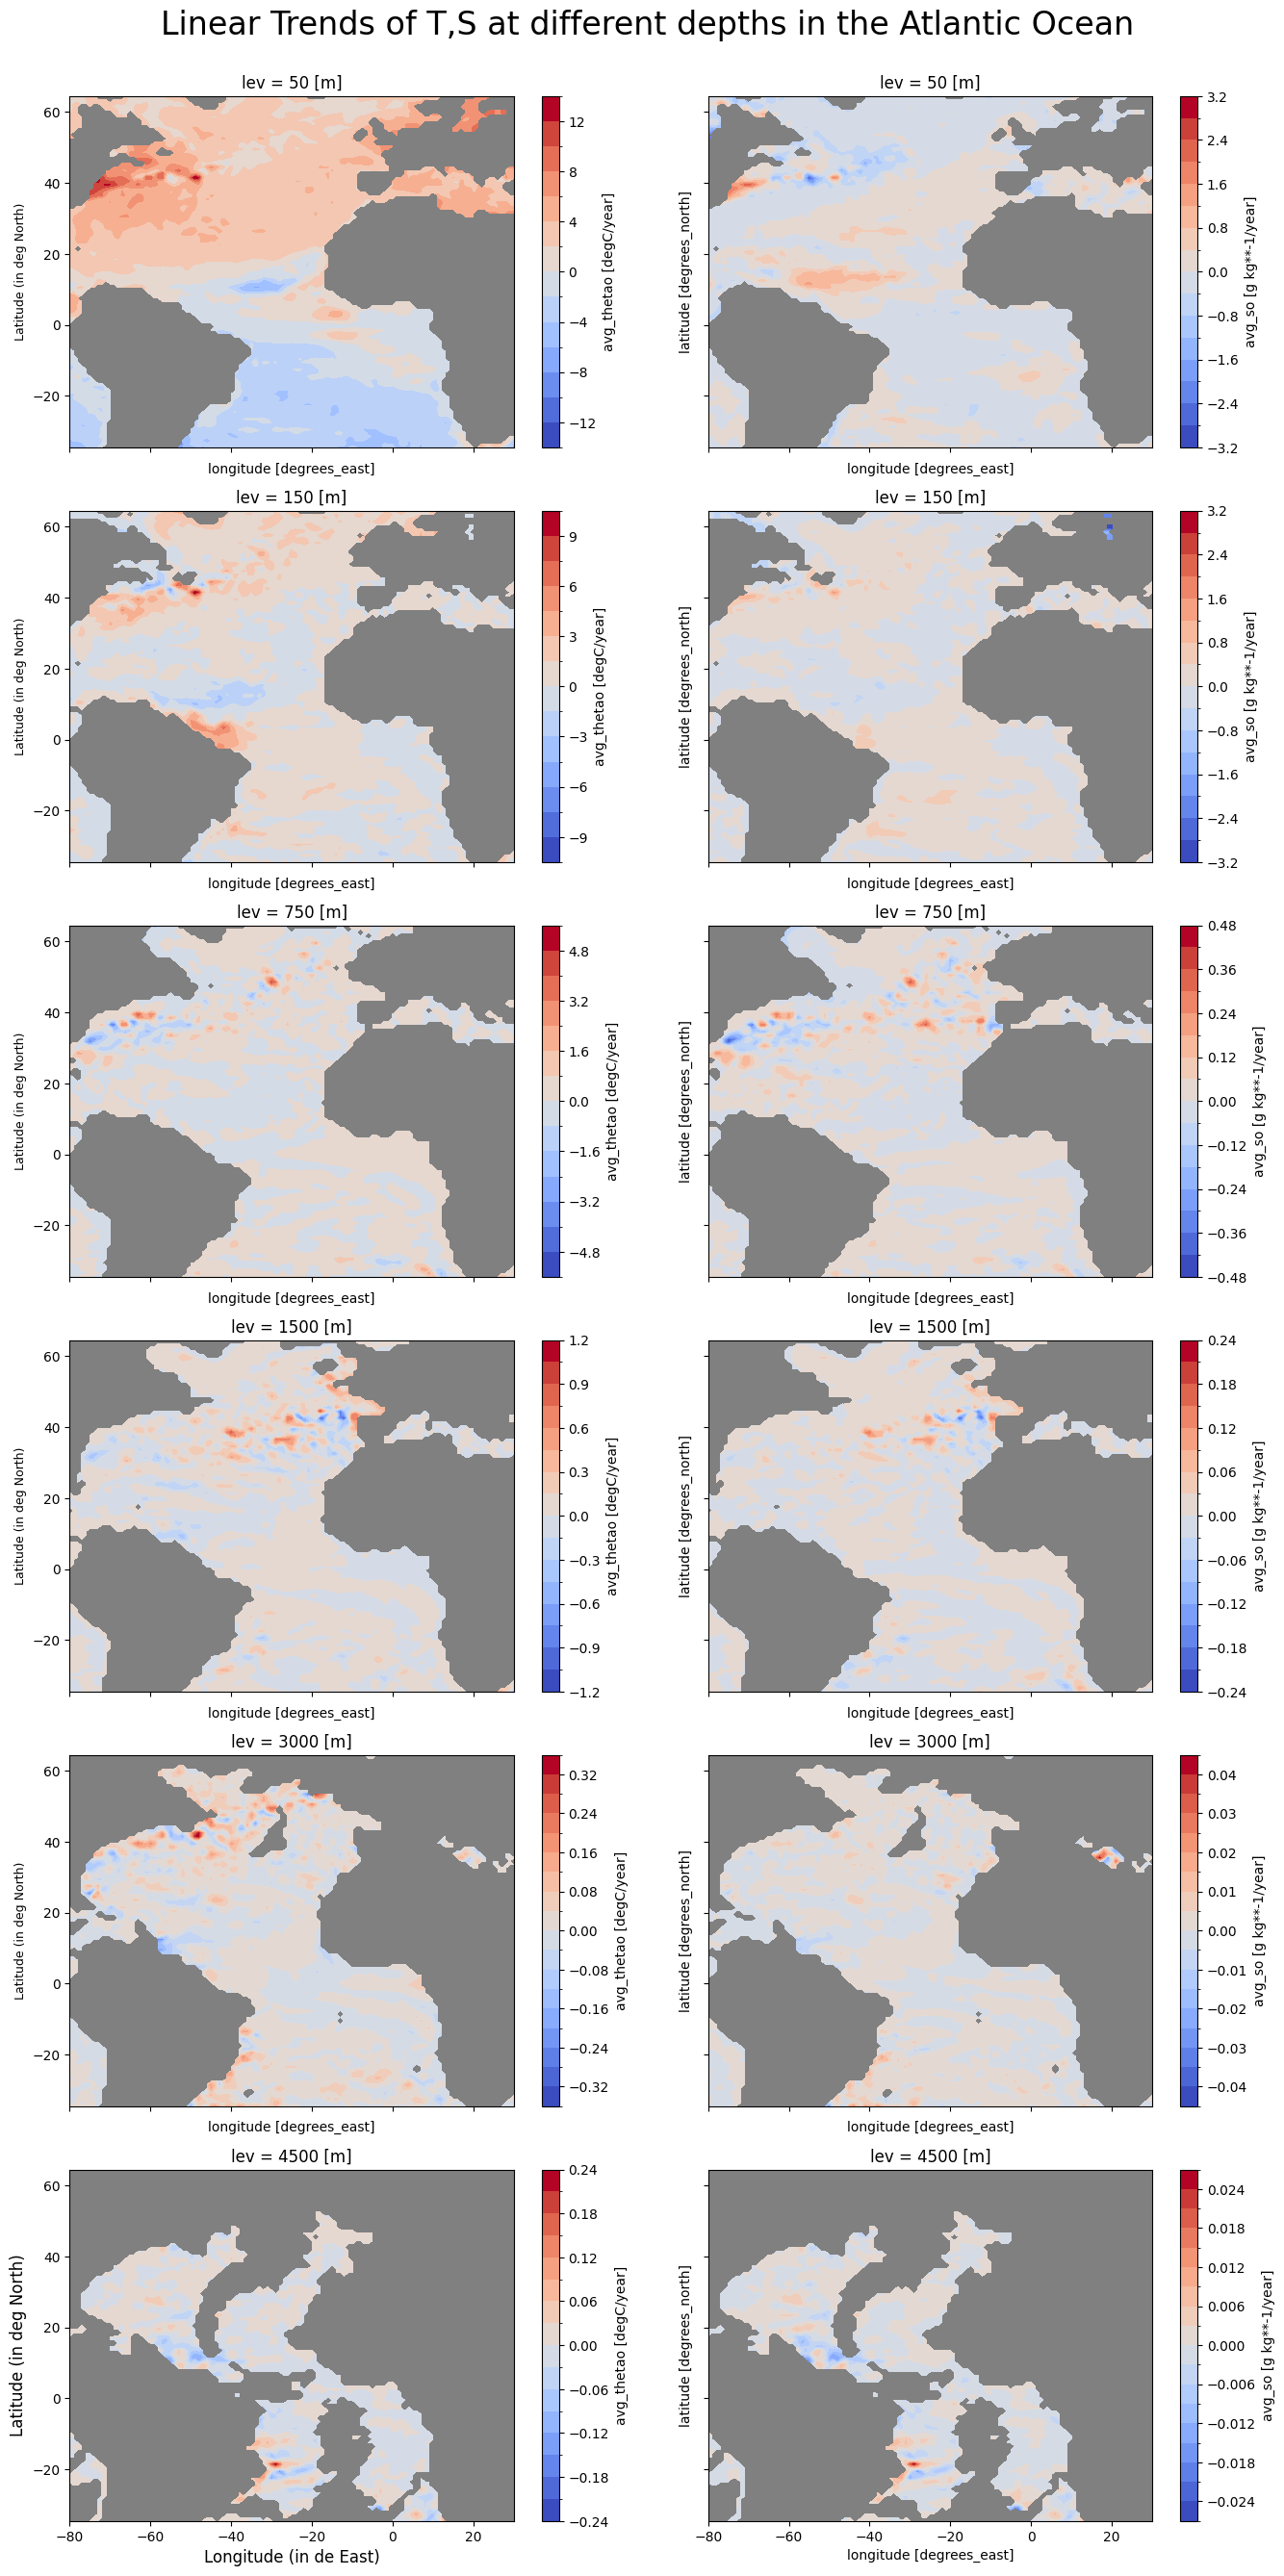

In [13]:
o3d_request["customise_level"]=True
o3d_request["levels"]=[50, 150, 750, 1500, 3000, 4500] 
trend = multilevel_trend(o3d_request)
trend.plot()


This is an example for the function that plots zonally averaged linear trends of T, S as a function of depth and latitude in this case for the Indian Ocean

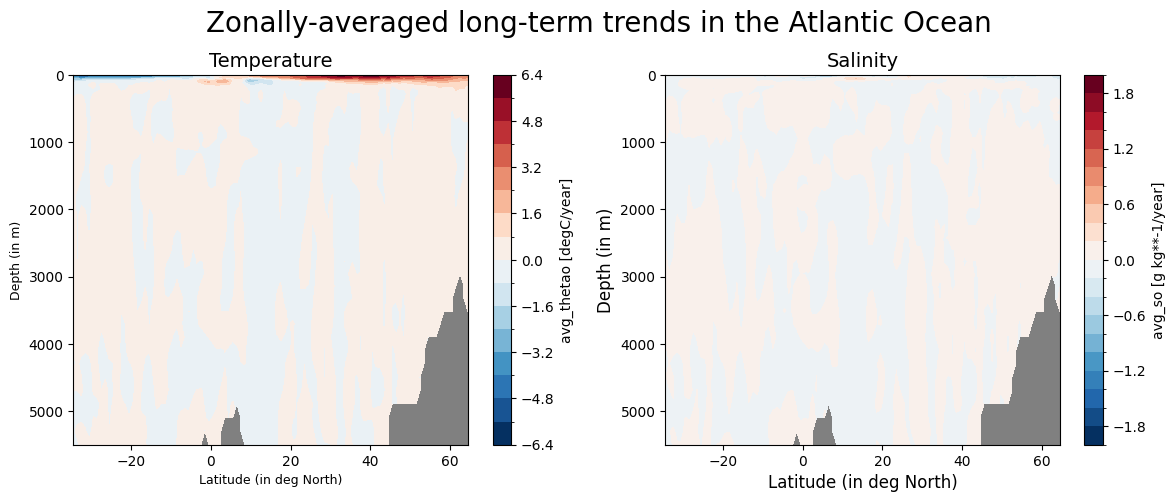

In [21]:
zonal_trend = zonal_mean_trend(o3d_request)
zonal_trend.plot()